# Checklist
 - Implement the 14 different lattice types
 - Use vector equations for things like limits to make plotting easier
 
## Next projects:
 - Lattice planes
 - Reciprocal lattices and the Wigner Seitz cell (bisecting lines, on/off switch)
 - Scattering along lattice planes
 - 2D band structure
 - Wave-packet applet
 - bloch functions

In [1]:
# Let's get the importing out of the way.
# Numpy for calculations, matplotlib for plotting.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Make the matplotlib plots interactive
%matplotlib notebook

In [2]:
# Inputs

# Lattice vectors (3 vectors of length 3)
a1 = np.array([1,0,0])
a2 = np.array([0, 1,0])
a3 = np.array([0, 0,1/2])
# Array of basis vectors
basis = np.array([[0, 0, 0]])
# Colors for each of the basis vectors
colors = ('xkcd:cement','b','b','b')
# Size multiplier for each of the atoms. Default is 1
sizes = (2,1,1,1)

# Gridline type:
# Hard: lines along cartesian axes at integer spacings
# SoftCar: Lines along cartesian axes. Takes into account nonequal lattice spacing
# LatticeVects: Lines along the latticevectors (only on lattice points)
GridType = "Soft"


In [3]:
size_default = 36

# We need the number of basis-vectors. 
# If there is only 1 basis vector, then len(np.shape(basis)) == 1
# otherwise the length is 2, and the first element is number of basis vectors
length_basis = np.shape(basis)
if len(length_basis) == 1:
    N_basis = 1
elif len(length_basis) > 1:
    N_basis = length_basis[0]

# Make a list, N_basis long, for the colors and sizes,
# if they're not specified.
c_name = colors.__class__.__name__
if c_name == "str":
    c = colors
    colors = []
    for i in range(N_basis):
        colors.append(c)
elif c_name == "list" and len(colors) != N_basis:
    c = colors[0]
    colors = []
    for i in range(N_basis):
        colors.append(c)

s_name = sizes.__class__.__name__
if s_name == "int" or s_name == "float":
    s = sizes
    sizes = []
    for i in range(N_basis):
        sizes.append(s)
elif s_name == "list" and len(sizes) != N_basis:
    s = sizes[0]
    sizes = []
    for i in range(N_basis):
        sizes.append(s)
        
# Test for orthogonality:
def orthogonality(a1,a2,a3):
    ortho12 = np.isclose(0,np.dot(a1,a2))
    ortho13 = np.isclose(0,np.dot(a1,a3))
    ortho23 = np.isclose(0,np.dot(a2,a3))
    if ortho12 and ortho13 and ortho23:
        return True
    else:
        return False

        
# set the range of lattice vectors to be calculated
nx_max, ny_max, nz_max = 4, 4, 4
nx_min, ny_min, nz_min = -2, -2, -2
# Calculate the amount of atomic positions to be calculated
numAtoms = (nx_max + 1 - nx_min) * (ny_max + 1 - ny_min) * (nz_max + 1 - nz_min) * N_basis
# Make a zero array for all of the atomic positions
AtomicPositions = np.zeros((numAtoms, 3))
AtomicColors = []
AtomicSizes = []
LatticePosition = []


# Loop over all chosen linear combinations of basis vectors and plot each 
counter = 0
for nx in range(nx_min, nx_max + 1):
    for ny in range(ny_min, ny_max + 1):
        for nz in range(nz_min, nz_max + 1 ):
            lattice_position = nx * a1 + ny * a2 + nz * a3
            
            for n_atom in range(N_basis):
                AtomicPositions[counter,] = lattice_position + basis[n_atom,]
                AtomicColors.append(colors[n_atom])
                AtomicSizes.append(size_default * sizes[n_atom])
                if (AtomicPositions[counter,] == lattice_position).all():
                    LatticePosition.append(True)
                else:
                    LatticePosition.append(False)
                counter += 1

# Another way to do this is to use itertools.product to create all permutations of -2,...,4 with repeat of 3
# And then use np.asarray() to convert this into a numpy array. The "problem" is that this doesn't allow
# one to have nx_max =/= ny_max, etc. All ranges must be equal.
# I should check to see which is fastest.
# Strike that above problem. Just pass it a list for each coordinate with the range and use no repeat.
# AtomicCoefficients = np.asarray(list(itertools.product(x,y,z)))
# Where x,y,z is list of integers from nx_min to nx_max etc.
# This would yield list of coefficients (nx,ny,nz), then we just multiply the first dimension by a1, the
# second by a2 and so on.
# But not now

In [4]:
# We need a way to hide points outside the limits
# The limits
x_min, y_min, z_min = 0, 0, 0
x_max, y_max, z_max = 2, 2, 2
atoms,dims = np.shape(AtomicPositions)

# A function to highlight points that are outside the limits of the plot
def Limiter(l, num, x_min, x_max, y_min, y_max, z_min, z_max):
    rows = []
    # loop over all row ID's
    for rowID in range(num):
        # if the atom is outside the limits, we append the row ID to a list
        row = l[rowID,]
        # (it's actually easier and prettier to check if they're inside)
        inside_x = x_min <= row[0] <= x_max
        inside_y = y_min <= row[1] <= y_max
        inside_z = z_min <= row[2] <= z_max
        inside = inside_x and inside_y and inside_z
        if not inside:
            rows.append(rowID)
    return rows

# Get the rows with the function above
rows = Limiter(AtomicPositions,atoms, x_min, x_max, y_min, y_max, z_min, z_max)
# delete all rows (axis 0 of the array) that are outside the limits 
AtomicPositions = np.delete(AtomicPositions, rows, 0);
# Go through the list of rows to delete in reverse order, and delete what's needed from colors and sizes
for ID in sorted(rows, reverse = True):
    del AtomicColors[ID]
    del AtomicSizes[ID]
    del LatticePosition[ID]

In [5]:
# Let's try and create some grid lines along the lattice vectors

# some observations regarding grid lines:
# - if we go along a lattice vector to a point, then we need gridlines that are along the direction of the other two lattice vectors
# A naïve approach would be to just plot 3 lines for each atomic position (after limiting). 
# This would create multiple copies of some gridlines, but it's an easy solution. Let's see how long it takes to compute!

# Create the plotting parameter for the gridlines.
# They use the equation r = r0+t*a, where:
# r0 is a fixed point (atomic position)
# a is a vector giving the direction of the gridline (lattice vector)
# t is a scaling parameter, creating the points along the line.
# We use halfinteger steps for t. That way we know that we'll properly hit other atomic positions.
# if we used linspace this wouldn't be the case
t = np.arange(-10,10,0.5)
len_t = np.size(t)

lines = []

# Create all gridlines needed and append them to the lines-list
for rowID in range(np.shape(AtomicPositions)[0]):
    if LatticePosition[rowID]:
        CurrentAtom = AtomicPositions[rowID,]
        line1 = CurrentAtom + np.outer(t,a1)
        line2 = CurrentAtom + np.outer(t,a2)
        line3 = CurrentAtom + np.outer(t,a3)  
        lines.append([line1,line2,line3])
    
# run through each line and clip points outside limits
pruned_lines = []
for atom in lines:
    for line in atom:
        # Get the points outside the plot and delete them
        rows = Limiter(line, len_t, x_min, x_max, y_min, y_max, z_min, z_max)
        line = np.delete(line,rows,0)
        
        # Because we're working with arrays we're passing copies, we need to append the pruned lines to a new list
        # And let's only add them if there are actually any points to plot
        line_length,_ = np.shape(line)
        if line_length > 0:
            pruned_lines.append(line)



<IPython.core.display.Javascript object>


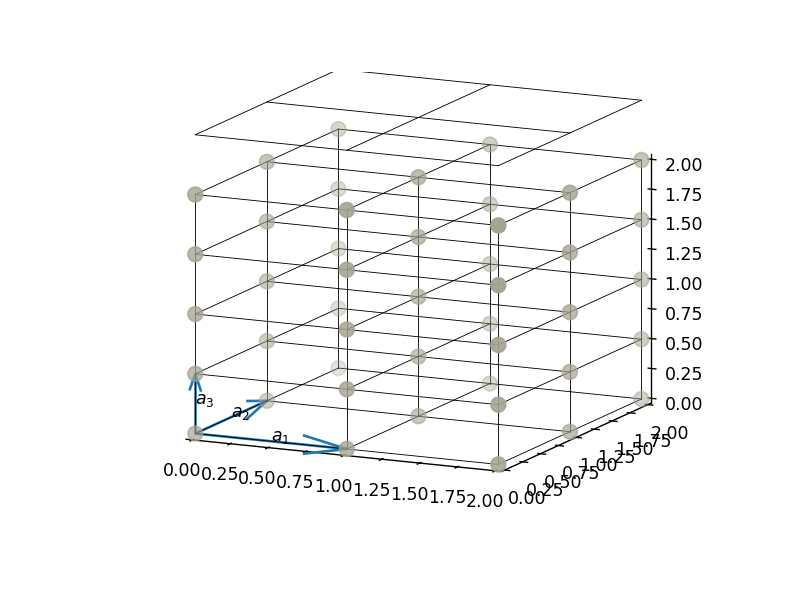

[[ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 2.  0.  0.]]


In [17]:
# Create the figure
fig = plt.figure()
ax = fig.gca(projection = "3d")

# Plot atoms. For now a single size and color
ax.scatter(AtomicPositions[:,0], AtomicPositions[:,1], AtomicPositions[:,2], c = AtomicColors, s = AtomicSizes)


# Create grid lines
g_col = 'k'
g_w = 0.5

if GridType == "Hard":
    for nx in range(int(np.ceil(x_min)), int(np.floor(x_max)) + 1):
        for ny in range(int(np.ceil(y_min)), int(np.floor(y_max)) + 1):
            ax.plot(np.array([nx, nx]), np.array([ny, ny]), np.array([np.ceil(z_min), np.floor(z_max)]), c = g_col, linewidth = g_w)

        for nz in range(int(np.ceil(z_min)), int(np.floor(z_max)) + 1):
            ax.plot(np.array([nx, nx]), np.array([np.ceil(z_min), np.floor(z_max)]), np.array([nz, nz]), c = g_col, linewidth = g_w)

    for ny in range(int(np.ceil(y_min)), int(np.floor(y_max)) + 1):
        for nz in range(int(np.ceil(z_min)), int(np.floor(z_max)) + 1,):
            ax.plot(np.array([np.ceil(x_min), np.floor(x_max)]), np.array([ny, ny]), np.array([nz, nz]), c = g_col, linewidth = g_w)

elif GridType == "LatticeVects":
    # gridlines along lattice vectors - really messy for non-orthogonal latticevectors
    for line in pruned_lines:
        ax.plot(line[:,0],line[:,1],line[:,2],c=g_col,linewidth=g_w)
elif GridType == "Soft":
    # A Way of finding atoms on cartesian axes
    # bool array of atoms with x = 0 and y = 0
    x0 = AtomicPositions[:,0] == 0
    y0 = AtomicPositions[:,1] == 0
    z0 = AtomicPositions[:,2] == 0

    # Pick Atoms that are on the cartesian axes
    OnZ = AtomicPositions[x0*y0, ]
    OnX = AtomicPositions[y0*z0, ]
    OnY = AtomicPositions[x0*z0, ]
    print(OnX)
    # Vector of values along the cartesian axes (above 0)
    Zvals = OnZ[OnZ[:,2]>0][:,2]
    Yvals = OnY[OnY[:,1]>0][:,1]
    Xvals = OnX[OnX[:,0]>0][:,0]
    # Get the minimum value, aka "grid spacing"
    Xspacing = np.min(Xvals)
    Yspacing = np.min(Yvals)
    Zspacing = np.min(Zvals)
    for nx in np.arange(x_min, x_max + 1, Xspacing):
        for ny in np.arange(y_min, y_max + 1, Yspacing):
            ax.plot(np.array([nx, nx]), np.array([ny, ny]), np.array([z_min, z_max]), c = g_col, linewidth = g_w)

        for nz in np.arange(z_min, z_max + 1, Zspacing):
            ax.plot(np.array([nx, nx]), np.array([y_min, y_max]), np.array([nz, nz]), c = g_col, linewidth = g_w)

    for ny in np.arange(y_min, y_max + 1, Yspacing):
        for nz in np.arange(z_min, z_max + 1, Zspacing):
            ax.plot(np.array([x_min, x_max]), np.array([ny, ny]), np.array([nz, nz]), c = g_col, linewidth = g_w)
    
else:
    print("No Gridlines Chosen")

# plot lattice vectors
ax.quiver(0, 0, 0, a1[0], a1[1], a1[2])
ax.quiver(0, 0, 0, a2[0], a2[1], a2[2])
ax.quiver(0, 0, 0, a3[0], a3[1], a3[2])
ax.text(a1[0]/2, a1[1]/2, a1[2]/2, '$a_1$')
ax.text(a2[0]/2, a2[1]/2, a2[2]/2, '$a_2$')
ax.text(a3[0]/2, a3[1]/2, a3[2]/2, '$a_3$')

# Set limits, orthographic projection (so we get the beautiful hexagons), no automatic gridlines, and no axes
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])
ax.set_proj_type('ortho')
ax.grid(False)
#plt.axis('off')

# make the panes transparent (the plot box)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

In [16]:
np.arange(z_min, z_max+1, Zspacing)

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5])

In [ ]:
# A way of dynamically setting max limits. 
# Take the max value for each of the cardinal directions, 
# for the three scaled lattice vectors (so x_max is max x value of 2*a1,2*a2 and 2*a3)
limVectX = 2*a1
limVectY = 2*a2
limVectZ = 2*a3
limVects = np.vstack((limVectX,limVectY,limVectZ))
maxs = np.amax(limVects,1)
#x_max,y_max,z_max = maxs